# Prescriptive Analytics: Inventory Management Optimization
### Author : Faiza Mahek
### Date   : 21-01-2025

In [1]:
# **1. Importing Necessary Libraries**
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# **2. Load the Dataset**
# Dataset: Product Demand Forecasting
data = "Historical Product Demand.csv"
data = pd.read_csv(data)
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [3]:
# **3. Data Preprocessing**
# Inspect for missing values and ensure the dataset is ready for analysis.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB
None


In [4]:
print(data.describe())

        Product_Code Warehouse Product_Category       Date Order_Demand
count        1048575   1048575          1048575    1037336      1048575
unique          2160         4               33       1729         3828
top     Product_1359    Whse_J     Category_019  2013/9/27        1000 
freq           16936    764447           481099       2075       112682


In [5]:
# Aggregating demand by product ID
demand_data = data.groupby('Product_Code').agg({'Order_Demand': 'sum', 'Warehouse': 'nunique'})
demand_data.rename(columns={'Order_Demand': 'Total_Demand', 'Warehouse': 'Unique_Warehouses'}, inplace=True)
print(demand_data.head())

                                                   Total_Demand  \
Product_Code                                                      
Product_0001  100 100 400 2000 3000 1000 1000 1000 1000 1000...   
Product_0002  50000 50000 30000 10000 30000 50000 15000 2000...   
Product_0003  400 300 300 700 300 200 400 700 400 400 500 50...   
Product_0004  900 100 100 100 300 100 100 100 300 100 200 10...   
Product_0005  200 200 200 100 200 100 200 500 500 1000 200 8...   

              Unique_Warehouses  
Product_Code                     
Product_0001                  2  
Product_0002                  2  
Product_0003                  2  
Product_0004                  1  
Product_0005                  1  


In [10]:
# Inspect the distribution of Total Demand to identify potential outliers
print(demand_data['Total_Demand'].describe())

# Ensure 'Total_Demand' column is numeric (convert if needed)
demand_data['Total_Demand'] = pd.to_numeric(demand_data['Total_Demand'], errors='coerce')

# Apply log transformation to handle extreme values in Total Demand
demand_data['Log_Total_Demand'] = np.log1p(demand_data['Total_Demand'])

count                                                  2160
unique                                                 2160
top       100 100 400 2000 3000 1000 1000 1000 1000 1000...
freq                                                      1
Name: Total_Demand, dtype: object


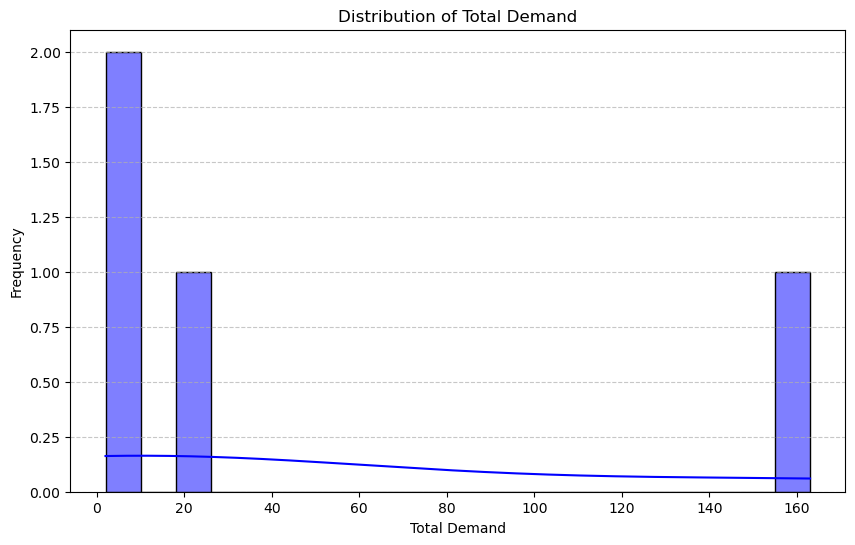

In [11]:
# **4. Visualizing the Distribution of Total Demand**
# Original Distribution
plt.figure(figsize=(10, 6))
sns.histplot(demand_data['Total_Demand'], bins=20, kde=True, color='blue')
plt.title("Distribution of Total Demand")
plt.xlabel("Total Demand")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

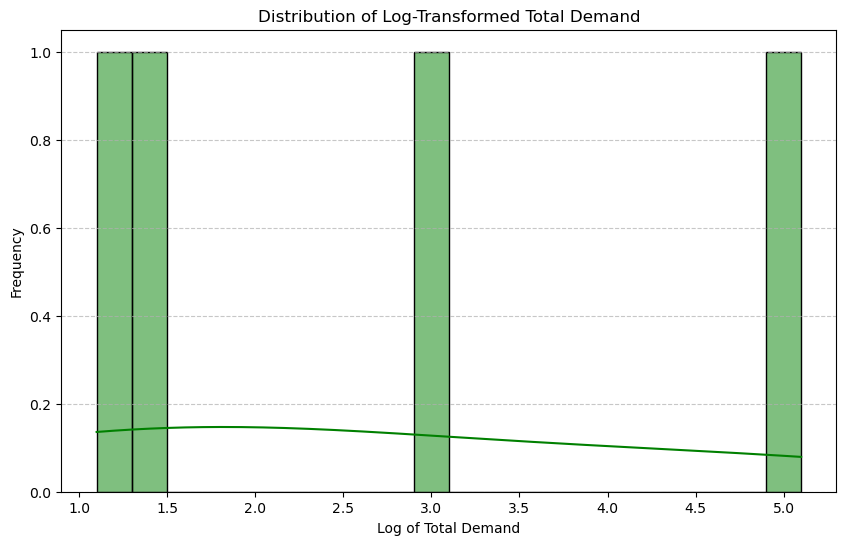

In [12]:
# Log-Transformed Distribution
plt.figure(figsize=(10, 6))
sns.histplot(demand_data['Log_Total_Demand'], bins=20, kde=True, color='green')
plt.title("Distribution of Log-Transformed Total Demand")
plt.xlabel("Log of Total Demand")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
# **5. Problem Definition: Optimize Inventory Management**
# Defining the variables for the optimization problem.
# Objective: Minimize cost while meeting demand and inventory constraints.

# Example parameters (customizable):
num_products = demand_data.shape[0]  # Number of products
cost_per_unit = 2  # Example cost per unit
holding_cost = 0.5  # Example holding cost per unit
warehouse_capacity = 1000  # Example warehouse capacity

demand = demand_data['Total_Demand'].fillna(0).values  # Ensure no NaN values in demand

In [15]:
# **6. Optimization Using Linear Programming (LP)**
from scipy.optimize import linprog

# Defining the cost coefficients (objective function)
c = cost_per_unit + holding_cost
c_vector = [c] * num_products

# Defining the inequality constraints:
# Constraint 1: Warehouse capacity
A = np.ones((1, num_products))
b = [warehouse_capacity]
# Constraint 2: Demand fulfillment (greater than or equal to demand)
A_eq = np.identity(num_products)
b_eq = demand

Optimal Solution Found: [0. 0. 0. ... 0. 0. 0.]
Minimum Cost: 470.0


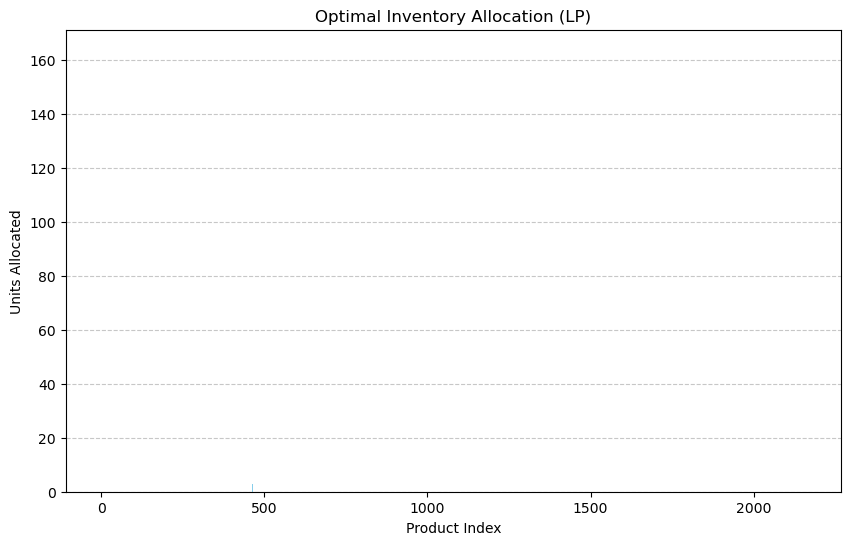

In [16]:
# Solve the LP problem
lp_solution = linprog(c_vector, A_eq=A_eq, b_eq=b_eq, bounds=(0, None), method='highs')

if lp_solution.success:
    print("Optimal Solution Found:", lp_solution.x)
    print("Minimum Cost:", lp_solution.fun)

    # Visualizing the LP solution
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_products), lp_solution.x, color='skyblue')
    plt.title("Optimal Inventory Allocation (LP)")
    plt.xlabel("Product Index")
    plt.ylabel("Units Allocated")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Optimization Failed:", lp_solution.message)

In [3]:
# **7. Sensitivity Analysis**
def sensitivity_analysis(param_name, param_range):
    costs = []
    c_vector = [cost_per_unit + holding_cost] * num_products  # Initialize default cost vector
    b = [warehouse_capacity]  # Initialize default warehouse capacity

    for param in param_range:
        if param_name == "cost_per_unit":
            c_vector = [param + holding_cost] * num_products
        elif param_name == "warehouse_capacity":
            b = [param]
        elif param_name == "holding_cost":
            c_vector = [cost_per_unit + param] * num_products
        else:
            continue

        lp_solution = linprog(c_vector, A_eq=A_eq, b_eq=b_eq, bounds=(0, None), method='highs')

        if lp_solution.success:
            costs.append(lp_solution.fun)
        else:
            costs.append(None)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, costs, marker='o', color='green')
    plt.title(f"Sensitivity Analysis: {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Total Cost")
    plt.grid(True)
    plt.show()


In [2]:
# Perform sensitivity analysis
sensitivity_analysis("cost_per_unit", range(1, 5))
sensitivity_analysis("warehouse_capacity", range(800, 1200, 50))
sensitivity_analysis("holding_cost", [0.2, 0.5, 1, 1.5])

NameError: name 'holding_cost' is not defined